**Content provided under a Creative Commons Attribution license, CC-BY 4.0. Code under Apache-2.0 License. (c) 2023 Wuqi Liang.**

**Last built on March 27, 2023.**

This is one of the notebooks for the [demos of AdaSmooth](https://github.com/ahddlwq/AdaSmooth-master/demos/cifar10), for visualizing the performance of AdaSmooth and its counterparts using Jupyter Notebook. 
AdaSmooth was proposed in the paper [AdaSmooth: A Novel Method for Adaptive Gradient Optimization].
You can view the [GitHub page of AdaSmooth](https://github.com/ahddlwq/AdaSmooth-master) to learn about the basic usage of AdaSmooth in popular deep learning frameworks.

You can read and follow along this notebook online, or clone and run on your local.

# Empirical Study on CIFAR-10

Let's play with the CIFAR-10 ([Krizhevsky & Hinton, 2009](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)) image classification task.
We will train two benchmark models: ResNet ([He et al., 2016](https://arxiv.org/abs/1512.03385)) and DenseNet ([Huang et al., 2017](https://arxiv.org/abs/1608.06993)) with AdaSmooth and other baseline methods: SGD, RMSProp, AdaGrad, Adam, AMSGrad, AdaBound and AdaMod.

We've already provided the code for training and evaluation [here](https://github.com/ahddlwq/AdaSmooth-master/demos/cifar10).
We employ the fixed budget of 200 epochs and reduce the learning rates by 10 after 150 epochs.
To run the experiments by yourself, please follow the [instructions](https://github.com/ahddlwq/AdaSmooth-master/demos/cifar10) and change the plotting parameter in this notebook correspodingly.

In [1]:
import os
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import numpy as np

LABELS = ['SGD', 'RMSProp', 'AdaGrad', 'Adam', 'AMSGrad','AdaBound', 'AdaMod','AdaSmooth']

In [2]:
def get_folder_path(use_pretrained=True):
    path = 'curve'
    if use_pretrained:
        path = os.path.join(path, 'pretrained')
    return path

In [3]:
def get_curve_data(use_pretrained=True, model='ResNet'):
    folder_path = get_folder_path(use_pretrained)
    filenames = [name for name in os.listdir(folder_path) if name.startswith(model.lower())]
    paths = [os.path.join(folder_path, name) for name in filenames]
    keys = [name.split('-')[1] for name in filenames]
    return {key: torch.load(fp) for key, fp in zip(keys, paths)}

In [17]:
def plot(use_pretrained=True, model='ResNet', optimizers=None, curve_type='train'):
    assert model in ['ResNet', 'DenseNet'], 'Invalid model name: {}'.format(model)
    assert curve_type in ['train', 'test'], 'Invalid curve type: {}'.format(curve_type)
    assert all(_ in LABELS for _ in optimizers), 'Invalid optimizer'
    
    file_name=('./image/cifar_{}_{}_acc.svg'.format(curve_type, model))
    curve_data = get_curve_data(use_pretrained, model=model)
        
    plt.figure()
    #plt.figure(dpi=300,figsize=(5,4))
    plt.title('{} Accuracy for {} on CIFAR-10'.format(curve_type.capitalize(), model))
    plt.xlabel('Epoch')
    plt.ylabel('{} Accuracy %'.format(curve_type.capitalize()))
    plt.ylim(80, 101 if curve_type == 'train' else 96)
    
    for optim in optimizers:
        linestyle = '--' if 'Smooth' in optim else '-'
        accuracies = np.array(curve_data[optim.lower()]['{}_acc'.format(curve_type)])
        #print(optim,accuracies.max())
        #if 'RMSProp' in optim:
        #    print(optim,accuracies) 
        plt.plot(accuracies, label=optim, ls=linestyle)
        
    plt.grid(ls='--')
    plt.legend()
    plt.savefig(file_name,format="svg")    
    # 应该在plt.savefig之后再调用plt.show()，否则保存的图片是空白
    plt.show()

The above function is for plotting the learning curves. To use your own data points, set `use_pretrained` as `False`.

## ResNet

First, let's see the results with ResNet-34.

<IPython.core.display.Javascript object>


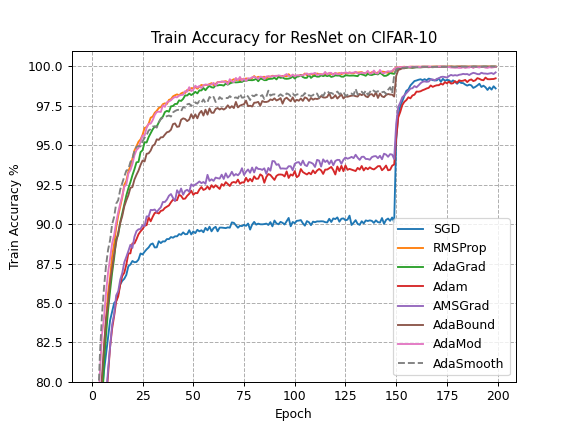

<IPython.core.display.Javascript object>


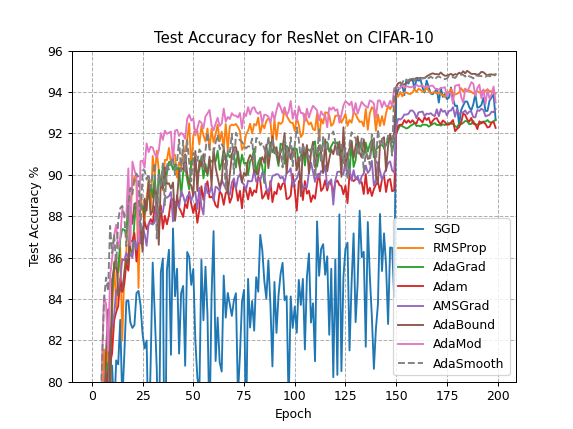

In [18]:
plot(use_pretrained=True, model='ResNet', optimizers=LABELS, curve_type='train')
plot(use_pretrained=True, model='ResNet', optimizers=LABELS, curve_type='test')


## DensetNet

Here're the results with DenseNet-121.

<IPython.core.display.Javascript object>


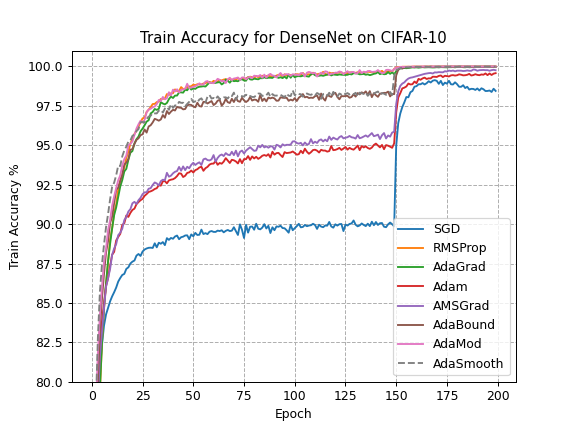

<IPython.core.display.Javascript object>


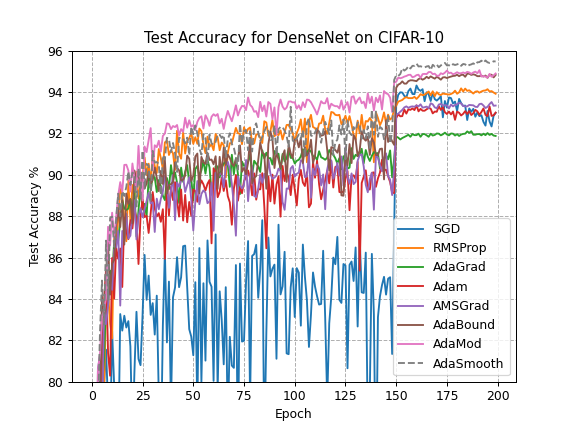

In [20]:
plot(use_pretrained=True, model='DenseNet', optimizers=LABELS, curve_type='train')
plot(use_pretrained=True, model='DenseNet', optimizers=LABELS, curve_type='test')

As can be seen from the figure, the overall performance of each algorithm on DenseNet-121 is similar to that on ResNet-34. Despite the relative bad generalization ability of adaptive methods, our proposed method AdaSmooth further smoothes the adaptive learning rate by estimating the first order moments of the individual adaptive learning rates and bounding learning rates to eliminate extremely learning rates, and obtain almost the best accuracy on the test set for both ResNet and DenseNet on CIFAR-10.